## 3-Way ANOVA

How each independent variable (type of treatments, risk of migraine and gender) interact to predict the pain score.

First we have to import the necessary libraries and disable unnecessary warnings...

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro, levene
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings("ignore")

Let's start with loading our data from Dr. Flisikowski's dataset.

In [45]:
# URL to the CSV file
url = "https://github.com/kflisikowski/ds/raw/master/headache.csv"

# Load the data into a DataFrame
headache = pd.read_csv(url)

# Display the first few rows of the data
print(headache.head())

   id gender risk treatment  pain_score
0   1   male  low         X     79.3117
1   2   male  low         X     76.8434
2   3   male  low         X     70.8324
3   4   male  low         X     81.1639
4   5   male  low         X     75.0522


Let's start with Descriptive Statistics...

In [46]:
# Grouping by 'treatment' and printing the descriptive statistics by .describe() from pandas
grouped_stats = headache.groupby('treatment')['pain_score'].describe()
print(grouped_stats)

# Counting manually
headache_X = headache[headache['treatment'] == 'X']
headache_Y = headache[headache['treatment'] == 'Y']
headache_Z = headache[headache['treatment'] == 'Z']

# headache_X
X_mean = headache_X.mean(numeric_only=True)
X_std = headache_X.std(numeric_only=True)
X_median = headache_X.median(numeric_only=True)

# headache_Y
Y_mean = headache_Y.mean(numeric_only=True)
Y_std = headache_Y.std(numeric_only=True)
Y_median = headache_Y.median(numeric_only=True)

# headache_Z
Z_mean = headache_Z.mean(numeric_only=True)
Z_std = headache_Z.std(numeric_only=True)
Z_median = headache_Z.median(numeric_only=True)

print("Headache_X Statistics:")
print("Mean:\n", X_mean)
print("Std Dev:\n", X_std)
print("Median:\n", X_median)

print("\nHeadache_Y Statistics:")
print("Mean:\n", Y_mean)
print("Std Dev:\n", Y_std)
print("Median:\n", Y_median)

print("\nHeadache_Z Statistics:")
print("Mean:\n", Z_mean)
print("Std Dev:\n", Z_std)
print("Median:\n", Z_median)


            count    mean    std     min     25%     50%     75%      max
treatment                                                                
X         24.0000 80.4530 8.5707 68.3602 74.8055 78.9518 83.5662 100.0000
Y         24.0000 76.2544 7.3075 63.7326 69.7993 76.4272 81.6734  91.1785
Z         24.0000 76.2378 5.8838 65.4494 71.6454 75.3563 80.6410  87.1423
Headache_X Statistics:
Mean:
 id           30.5000
pain_score   80.4530
dtype: float64
Std Dev:
 id           20.6313
pain_score    8.5707
dtype: float64
Median:
 id           30.5000
pain_score   78.9518
dtype: float64

Headache_Y Statistics:
Mean:
 id           36.5000
pain_score   76.2544
dtype: float64
Std Dev:
 id           20.6313
pain_score    7.3075
dtype: float64
Median:
 id           36.5000
pain_score   76.4272
dtype: float64

Headache_Z Statistics:
Mean:
 id           42.5000
pain_score   76.2378
dtype: float64
Std Dev:
 id           20.6313
pain_score    5.8838
dtype: float64
Median:
 id           42.5000
pain

We have to check the normality first! We will use Shapiro-Wilk test since the sample size is 72! We can also use the Anderson-Darling test, but Shapiro is more accurate.

In [47]:
headaches = [("X", headache_X), ("Y", headache_Y), ("Z", headache_Z)]
alpha = 0.05

for name, group in headaches:
    stat, p_value = shapiro(group['pain_score'])
    print(f"Group {name}: W-statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value > alpha:
        print("Normal distribution")
    else:
        print("Not normal distribution")


Group X: W-statistic=0.9388, p-value=0.1538
Normal distribution
Group Y: W-statistic=0.9741, p-value=0.7675
Normal distribution
Group Z: W-statistic=0.9653, p-value=0.5537
Normal distribution


Let's check the homogenity of variances...

In [48]:
stat, p_value = levene(
    headache_X['pain_score'],
    headache_Y['pain_score'],
    headache_Z['pain_score']
)

print(f"Levene’s test: Statistic={stat:.4f}, p-value={p_value:.4f}")
if p_value > 0.05:
    print("Homogeneity of variances is satisfied (p > 0.05).")
else:
    print("Homogeneity of variances is violated (p ≤ 0.05).")


Levene’s test: Statistic=0.8240, p-value=0.4429
Homogeneity of variances is satisfied (p > 0.05).


Homogenity of variances was satisfied, now let's put everything on the boxplots.

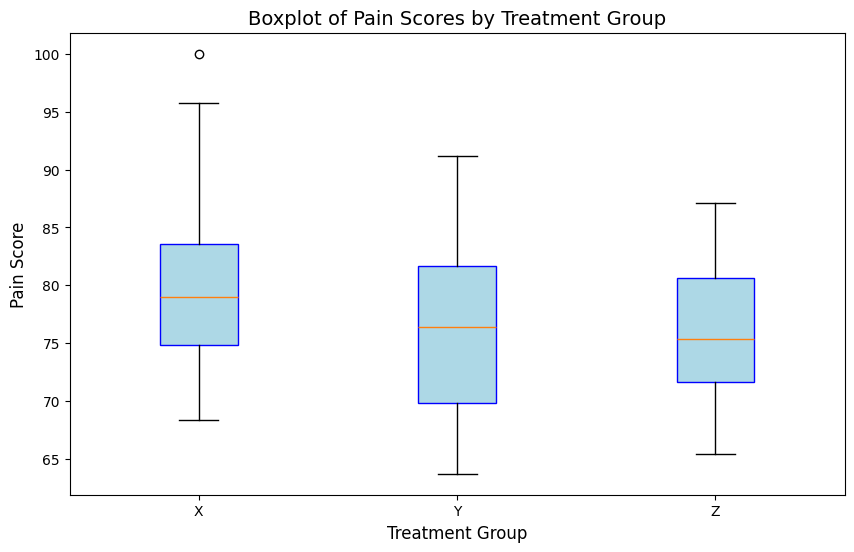

In [49]:
# Adding group to identify in the DataFrame
headache_X['group'] = 'X'
headache_Y['group'] = 'Y'
headache_Z['group'] = 'Z'

# Combining all into one DataFrame
headache_combined = pd.concat([headache_X, headache_Y, headache_Z])

# Boxplot groups
groups = ['X', 'Y', 'Z']
data = [headache_combined[headache_combined['group'] == g]['pain_score'] for g in groups]
 
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=groups, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'))

plt.title('Boxplot of Pain Scores by Treatment Group', fontsize=14)
plt.xlabel('Treatment Group', fontsize=12)
plt.ylabel('Pain Score', fontsize=12)
plt.show()


Here's where the fun begins. Let's perform the ANOVA...

In [50]:
model = ols('pain_score ~ C(treatment) * C(gender) * C(risk)', data=headache_combined).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

significant_effects = anova_table[anova_table["PR(>F)"] < 0.05]

print(significant_effects)


                                  sum_sq     df       F  PR(>F)
C(treatment)                    283.1680 2.0000  7.3177  0.0014
C(gender)                       313.3588 1.0000 16.1957  0.0002
C(risk)                        1793.5558 1.0000 92.6988  0.0000
C(treatment):C(gender)          129.1823 2.0000  3.3384  0.0422
C(treatment):C(gender):C(risk)  286.5956 2.0000  7.4063  0.0013


After filtering the results we can see that: Treatement x Gender and Treatement x Gender x Risk interactions make a significant difference.

Let's see in what variants...

In [51]:
# Tukey HSD for treatment x gender
headache_combined["treatment_gender"] = headache_combined["treatment"] + "_" + headache_combined["gender"]

tukey_treatment_gender = pairwise_tukeyhsd(
    endog=headache_combined["pain_score"],
    groups=headache_combined["treatment_gender"],
    alpha=0.05
)

# Filtering significant results (True) for treatment x gender
significant_treatment_gender = tukey_treatment_gender.summary()
significant_treatment_gender_rows = [
    row for row in significant_treatment_gender.data[1:] if row[-1] == True
]
if significant_treatment_gender_rows:
    print("\nSignificant results for treatment x gender:")
    for row in significant_treatment_gender_rows:
        print(row)
else:
    print("No significant results for treatment x gender.")


# Tukey HSD for treatment x gender x risk
for risk_level in headache_combined["risk"].unique():
    subset = headache_combined[headache_combined["risk"] == risk_level]
    subset["treatment_gender"] = subset["treatment"] + "_" + subset["gender"]

    tukey = pairwise_tukeyhsd(
        endog=subset["pain_score"],
        groups=subset["treatment_gender"],
        alpha=0.05
    )

# Filtering significant results (True) for each risk level
significant_risk = tukey.summary()
significant_risk_rows = [row for row in significant_risk.data[1:] if row[-1] == True]

print(f"\nTukey HSD for Risk Level: {risk_level}")
if significant_risk_rows:
    print("Significant results:")
    for row in significant_risk_rows:
        print(row)
else:
    print("No significant results for this risk level.")



Significant results for treatment x gender:
['X_male', 'Y_female', np.float64(-9.6267), np.float64(0.0162), np.float64(-18.0628), np.float64(-1.1906), np.True_]
['X_male', 'Z_female', np.float64(-8.988), np.float64(0.0302), np.float64(-17.424), np.float64(-0.5519), np.True_]

Tukey HSD for Risk Level: high
Significant results:
['X_female', 'X_male', np.float64(13.8738), np.float64(0.0002), np.float64(5.6049), np.float64(22.1427), np.True_]
['X_male', 'Y_female', np.float64(-11.5635), np.float64(0.0024), np.float64(-19.8325), np.float64(-3.2946), np.True_]
['X_male', 'Y_male', np.float64(-10.3973), np.float64(0.0074), np.float64(-18.6662), np.float64(-2.1284), np.True_]
['X_male', 'Z_female', np.float64(-11.7037), np.float64(0.0021), np.float64(-19.9726), np.float64(-3.4348), np.True_]
['X_male', 'Z_male', np.float64(-13.0581), np.float64(0.0005), np.float64(-21.327), np.float64(-4.7892), np.True_]


So we see the confirmation, that Treatement x Gender and Treatement x Gender x Risk interactions make a significant difference. Our prove are differences in interactions printed above.

Let's now see the graphs.

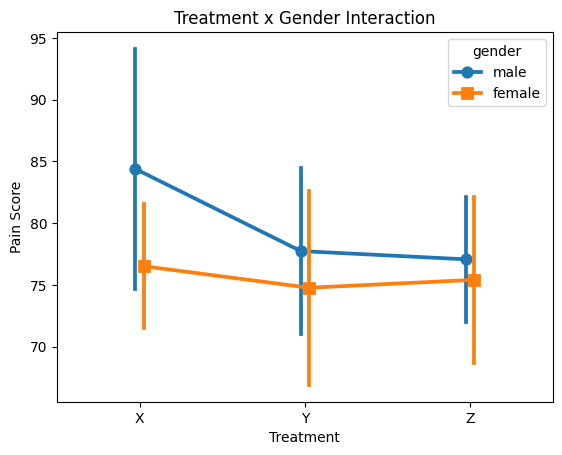

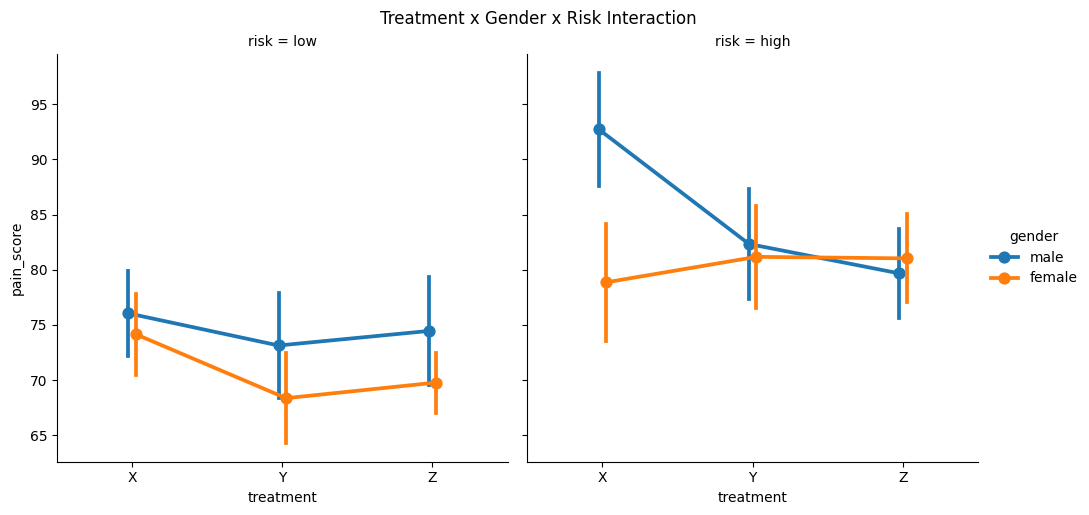

In [52]:
sns.pointplot(
    data=headache_combined, 
    x="treatment", 
    y="pain_score", 
    hue="gender", 
    dodge=True, 
    markers=["o", "s"],
    errorbar="sd"
)
plt.title("Treatment x Gender Interaction")
plt.ylabel("Pain Score")
plt.xlabel("Treatment")
plt.show()

sns.catplot(
    data=headache_combined,
    x="treatment",
    y="pain_score",
    hue="gender",
    col="risk",
    kind="point",
    errorbar="sd",
    dodge=True
)
plt.suptitle("Treatment x Gender x Risk Interaction", y=1.02)
plt.show()

